<a href="https://colab.research.google.com/github/Pial-Khan/Music-Genre-Classification-using-ANN-and-CNN/blob/main/Music_Genre_Classification_using_ANN_and_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
example_file = "/content/drive/MyDrive/ML Lab(Music genre classification)/GTZAN dataset/Data/genres_original/disco/disco.00001.wav"

In [47]:
# load audio file with Librosa
signal, sample_rate = librosa.load(example_file)

In [48]:
print(signal)

[-0.18777466 -0.23693848 -0.15542603 ...  0.03741455  0.10574341
  0.09619141]


In [49]:
print(sample_rate)

22050


In [50]:
FIG_SIZE = (8,4)

Text(0.5, 1.0, 'Waveform')

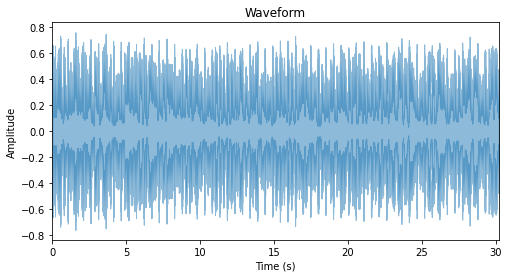

In [51]:
# WAVEFORM
plt.figure(figsize=FIG_SIZE)
librosa.display.waveplot(signal, sample_rate, alpha=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")

In [52]:
# Fourier Transform (FFT) - Frequency Domain
fft = np.fft.fft(signal)

In [53]:
# Calculate the Magnitude (abs values on complex numbers)
spectrum = np.abs(fft)

In [54]:
# Create the Frequency variable
f = np.linspace(0, sample_rate, len(spectrum))

Text(0.5, 1.0, 'Power Spectrum')

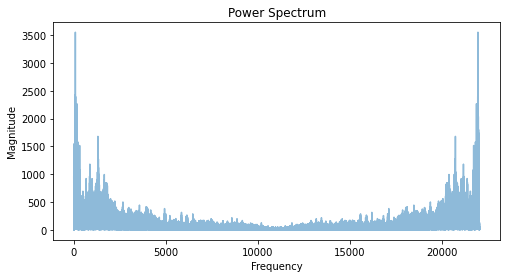

In [55]:
# Plot Spectrum
plt.figure(figsize=FIG_SIZE)
plt.plot(f, spectrum, alpha=0.5)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power Spectrum")

In [56]:
# Take half of the spectrum and frequency
left_spectrum = spectrum[:int(len(spectrum)/2)]
left_f = f[:int(len(spectrum)/2)]

Text(0.5, 1.0, 'Power Spectrum')

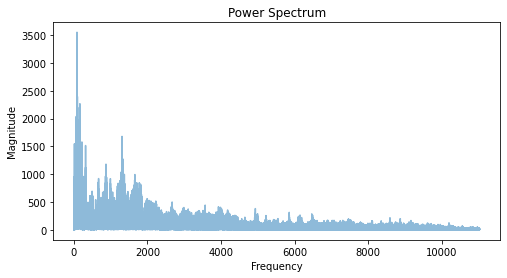

In [57]:
# Plot Spectrum
plt.figure(figsize=FIG_SIZE)
plt.plot(left_f, left_spectrum, alpha=0.5)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power Spectrum")

In [58]:
# Spectrogram (STFT)
hop_length = 512 # num. of samples
n_fft = 2048 # num. of samples for window

In [59]:
# Perform STFT
stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)

In [60]:
# Calculate the Magnitude (abs values on complex numbers)
spectrogram = np.abs(stft)

Text(0.5, 1.0, 'Spectrogram')

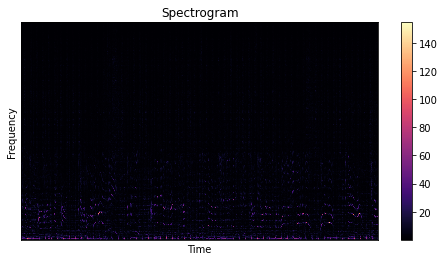

In [61]:
# Plot the Spectrogram
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(spectrogram, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.title("Spectrogram")

In [62]:
# Apply Logarithm to get values in Decibels
log_spectrogram = librosa.amplitude_to_db(spectrogram)

Text(0.5, 1.0, 'Spectrogram (dB)')

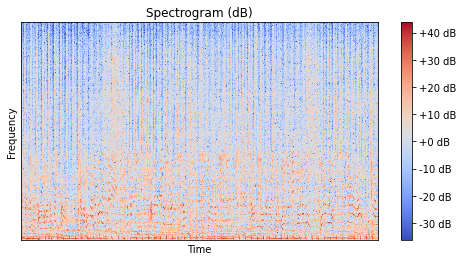

In [63]:
# Plot the Spectrogram in Decibels
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")

In [64]:
# MFCCs (we use 13 MFCCs)
MFCCs = librosa.feature.mfcc(signal, sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

Text(0.5, 1.0, 'MFCCs')

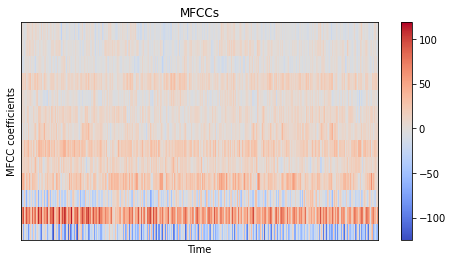

In [65]:
# Plot MFCCs
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs")

In [66]:
import json
import os
import math

In [67]:
DATASET_PATH = "/content/drive/MyDrive/ML Lab(Music genre classification)/GTZAN dataset/Data/genres_original"
JSON_PATH = "/content/drive/MyDrive/ML Lab(Music genre classification)/GTZAN dataset/Data/genres_original/data_10.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

In [68]:
def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    """Extracts MFCCs from music dataset and saves them into a json file along with genre labels.
        """

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

		# load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # process all segments of audio file
                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T

                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print("{}, segment:{}".format(file_path, d+1))

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

In [69]:
save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/ML Lab(Music genre classification)/GTZAN dataset/Data/genres_original/disco/disco.00000.wav, segment:5
/content/drive/MyDrive/ML Lab(Music genre classification)/GTZAN dataset/Data/genres_original/disco/disco.00000.wav, segment:6
/content/drive/MyDrive/ML Lab(Music genre classification)/GTZAN dataset/Data/genres_original/disco/disco.00000.wav, segment:7
/content/drive/MyDrive/ML Lab(Music genre classification)/GTZAN dataset/Data/genres_original/disco/disco.00000.wav, segment:8
/content/drive/MyDrive/ML Lab(Music genre classification)/GTZAN dataset/Data/genres_original/disco/disco.00000.wav, segment:9
/content/drive/MyDrive/ML Lab(Music genre classification)/GTZAN dataset/Data/genres_original/disco/disco.00000.wav, segment:10
/content/drive/MyDrive/ML Lab(Music genre classification)/GTZAN dataset/Data/genres_original/disco/disco.00002.wav, segment:1
/content/drive/MyDrive/ML Lab(Music genre classification)/GTZAN da

In [122]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

import matplotlib.pyplot as plt
import random

import librosa
import math

### Load Data

In [71]:
# path to json
DATA_PATH = "/content/drive/MyDrive/ML Lab(Music genre classification)/GTZAN dataset/Data/genres_original/data_10.json"

In [72]:
def load_data(data_path):

    with open(data_path, "r") as f:
        data = json.load(f)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")

    return  X, y

In [73]:
# load data
X, y = load_data(DATA_PATH)

Data succesfully loaded!


In [74]:
X.shape

(9986, 130, 13)

In [75]:
# create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Simple ANN

In [76]:
# build network topology
model = keras.Sequential([

    # input layer
    keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),

    # 1st dense layer
    keras.layers.Dense(512, activation='relu'),

    # 2nd dense layer
    keras.layers.Dense(256, activation='relu'),

    # 3rd dense layer
    keras.layers.Dense(64, activation='relu'),

    # output layer
    keras.layers.Dense(10, activation='softmax')
])

In [77]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [78]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 1690)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               865792    
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_10 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_11 (Dense)             (None, 10)                650       
Total params: 1,014,218
Trainable params: 1,014,218
Non-trainable params: 0
_________________________________________________________________


In [79]:
# train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=50)

Epoch 1/50
250/250 [==============================] - 4s 11ms/step - loss: 6.5111 - accuracy: 0.2789 - val_loss: 2.0740 - val_accuracy: 0.3283
Epoch 2/50
250/250 [==============================] - 3s 10ms/step - loss: 1.8953 - accuracy: 0.3594 - val_loss: 1.9194 - val_accuracy: 0.3468
Epoch 3/50
250/250 [==============================] - 3s 10ms/step - loss: 1.7303 - accuracy: 0.4004 - val_loss: 1.8504 - val_accuracy: 0.3784
Epoch 4/50
250/250 [==============================] - 3s 10ms/step - loss: 1.6324 - accuracy: 0.4326 - val_loss: 1.9976 - val_accuracy: 0.3408
Epoch 5/50
250/250 [==============================] - 3s 10ms/step - loss: 1.6218 - accuracy: 0.4326 - val_loss: 1.8669 - val_accuracy: 0.4249
Epoch 6/50
250/250 [==============================] - 3s 10ms/step - loss: 1.4566 - accuracy: 0.4910 - val_loss: 1.8025 - val_accuracy: 0.4515
Epoch 7/50
250/250 [==============================] - 3s 10ms/step - loss: 1.3996 - accuracy: 0.5015 - val_loss: 1.8099 - val_accuracy: 0.4389

In [80]:
def plot_history(history):

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    
    plt.show()

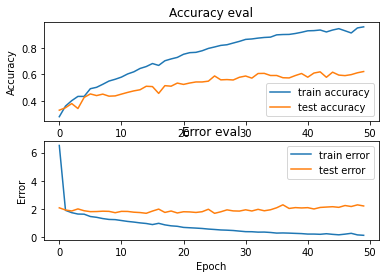

In [81]:
# plot accuracy and error as a function of the epochs
plot_history(history)

### Managing Overfitting

In [82]:
# build network topology
model_regularized = keras.Sequential([

    # input layer
    keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),

    # 1st dense layer
    keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # 2nd dense layer
    keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # 3rd dense layer
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # output layer
    keras.layers.Dense(10, activation='softmax')
])

In [83]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model_regularized.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [123]:
model_regularized.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 1690)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               865792    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)               

In [84]:
# train model
history = model_regularized.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=100)

Epoch 1/100
250/250 [==============================] - 5s 16ms/step - loss: 22.4354 - accuracy: 0.1671 - val_loss: 3.6207 - val_accuracy: 0.2182
Epoch 2/100
250/250 [==============================] - 4s 15ms/step - loss: 6.1548 - accuracy: 0.1670 - val_loss: 3.4856 - val_accuracy: 0.1251
Epoch 3/100
250/250 [==============================] - 4s 15ms/step - loss: 4.2742 - accuracy: 0.1467 - val_loss: 3.4849 - val_accuracy: 0.1346
Epoch 4/100
250/250 [==============================] - 4s 15ms/step - loss: 3.7852 - accuracy: 0.1611 - val_loss: 3.4624 - val_accuracy: 0.1406
Epoch 5/100
250/250 [==============================] - 4s 15ms/step - loss: 3.6199 - accuracy: 0.1736 - val_loss: 3.4089 - val_accuracy: 0.1662
Epoch 6/100
250/250 [==============================] - 4s 15ms/step - loss: 3.5265 - accuracy: 0.1870 - val_loss: 3.3780 - val_accuracy: 0.1817
Epoch 7/100
250/250 [==============================] - 4s 15ms/step - loss: 3.4552 - accuracy: 0.1826 - val_loss: 3.3397 - val_accuracy

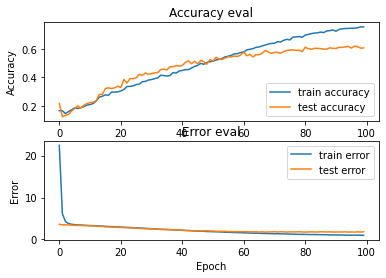

In [85]:
# plot accuracy and error as a function of the epochs
plot_history(history)

# Convolutional Neural Network

In [87]:
# create train, validation and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

# add an axis to input sets
X_train = X_train[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [88]:
X_train.shape

(6390, 130, 13, 1)

In [89]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)

In [90]:
# build the CNN
model_cnn = keras.Sequential()

# 1st conv layer
model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# 2nd conv layer
model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# 3rd conv layer
model_cnn.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
model_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# flatten output and feed it into dense layer
model_cnn.add(keras.layers.Flatten())
model_cnn.add(keras.layers.Dense(64, activation='relu'))
model_cnn.add(keras.layers.Dropout(0.3))

# output layer
model_cnn.add(keras.layers.Dense(10, activation='softmax'))

In [91]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model_cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [92]:
model_cnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 11, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 6, 32)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 6, 32)         128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 4, 32)         9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 2, 32)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 2, 32)         128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 1, 32)        

In [93]:
# train model
history = model_cnn.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=50)

Epoch 1/50
200/200 [==============================] - 14s 67ms/step - loss: 2.2997 - accuracy: 0.2465 - val_loss: 1.7629 - val_accuracy: 0.3705
Epoch 2/50
200/200 [==============================] - 13s 67ms/step - loss: 1.7666 - accuracy: 0.3756 - val_loss: 1.4994 - val_accuracy: 0.4487
Epoch 3/50
200/200 [==============================] - 13s 67ms/step - loss: 1.6030 - accuracy: 0.4290 - val_loss: 1.3927 - val_accuracy: 0.4869
Epoch 4/50
200/200 [==============================] - 13s 67ms/step - loss: 1.4966 - accuracy: 0.4742 - val_loss: 1.3158 - val_accuracy: 0.5213
Epoch 5/50
200/200 [==============================] - 13s 67ms/step - loss: 1.4166 - accuracy: 0.5008 - val_loss: 1.2597 - val_accuracy: 0.5463
Epoch 6/50
200/200 [==============================] - 14s 68ms/step - loss: 1.3522 - accuracy: 0.5136 - val_loss: 1.2231 - val_accuracy: 0.5519
Epoch 7/50
200/200 [==============================] - 14s 69ms/step - loss: 1.2726 - accuracy: 0.5416 - val_loss: 1.1748 - val_accuracy:

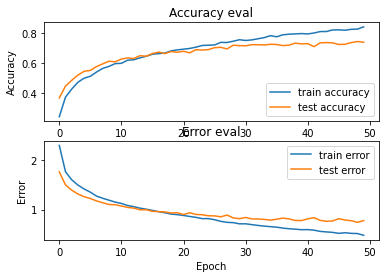

In [94]:
# plot accuracy and error as a function of the epochs
plot_history(history)

In [95]:
# evaluate model on Test Set
test_loss, test_acc = model_cnn.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

63/63 - 1s - loss: 0.7893 - accuracy: 0.7397

Test accuracy: 0.739739716053009


In [96]:
model_cnn.save("/content/drive/MyDrive/ML Lab(Music genre classification)/Music_Genre_10_CNN")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML Lab(Music genre classification)/Music_Genre_10_CNN/assets


In [97]:
model_cnn.save("/content/drive/MyDrive/ML Lab(Music genre classification)/Music_Genre_10_CNN.h5")

In [98]:
# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model("/content/drive/MyDrive/ML Lab(Music genre classification)/Music_Genre_10_CNN.h5")

### Prediction on Test Set

In [99]:
# pick a sample to predict from the test set
X_to_predict = X_test[100]
y_to_predict = y_test[100]

In [100]:
X_to_predict.shape

(130, 13, 1)

In [101]:
print("Real Genre:", y_to_predict)

Real Genre: 9


In [102]:
# add a dimension to input data for sample - model.predict() expects a 4d array in this case
X_to_predict = X_to_predict[np.newaxis, ...] # array shape (1, 130, 13, 1)

In [103]:
X_to_predict.shape

(1, 130, 13, 1)

In [104]:
# perform prediction
prediction = model_cnn.predict(X_to_predict)

In [105]:
# get index with max value
predicted_index = np.argmax(prediction, axis=1)

print("Predicted Genre:", int(predicted_index))

Predicted Genre: 9


In [118]:
# pick a sample to predict from the test set
X_to_predict = X_test[50]
y_to_predict = y_test[50]

print("Real Genre:", y_to_predict)

X_to_predict = X_to_predict[np.newaxis, ...]

prediction = model_cnn.predict(X_to_predict)

# get index with max value
predicted_index = np.argmax(prediction, axis=1)

print("Predicted Genre:", int(predicted_index))





Real Genre: 0
Predicted Genre: 3


In [119]:
len(X_test)

1998

In [120]:
for n in range(10):

  i = random.randint(0,len(X_test))
  # pick a sample to predict from the test set
  X_to_predict = X_test[i]
  y_to_predict = y_test[i]

  print("\nReal Genre:", y_to_predict)

  X_to_predict = X_to_predict[np.newaxis, ...]

  prediction = model_cnn.predict(X_to_predict)

  # get index with max value
  predicted_index = np.argmax(prediction, axis=1)

  print("Predicted Genre:", int(predicted_index))



Real Genre: 1
Predicted Genre: 8

Real Genre: 7
Predicted Genre: 7

Real Genre: 5
Predicted Genre: 5

Real Genre: 1
Predicted Genre: 1

Real Genre: 7
Predicted Genre: 7

Real Genre: 7
Predicted Genre: 7

Real Genre: 3
Predicted Genre: 3

Real Genre: 4
Predicted Genre: 0

Real Genre: 9
Predicted Genre: 9

Real Genre: 2
Predicted Genre: 8


### Prediction on New Songs

In [109]:
# Audio files pre-processing
def process_input(audio_file, track_duration):

  SAMPLE_RATE = 22050
  NUM_MFCC = 13
  N_FTT=2048
  HOP_LENGTH=512
  TRACK_DURATION = track_duration # measured in seconds
  SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
  NUM_SEGMENTS = 10

  samples_per_segment = int(SAMPLES_PER_TRACK / NUM_SEGMENTS)
  num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / HOP_LENGTH)

  signal, sample_rate = librosa.load(audio_file, sr=SAMPLE_RATE)
  
  for d in range(10):

    # calculate start and finish sample for current segment
    start = samples_per_segment * d
    finish = start + samples_per_segment

    # extract mfcc
    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=NUM_MFCC, n_fft=N_FTT, hop_length=HOP_LENGTH)
    mfcc = mfcc.T

    return mfcc

In [110]:
genre_dict = {0:"blues",1:"classical",2:"country",3:"disco",4:"hiphop",5:"jazz",6:"pop",7:"metal",8:"reggae",9:"rock"}

In [111]:
new_input_mfcc = process_input("/content/drive/MyDrive/ML Lab(Music genre classification)/GTZAN dataset/Data/genres_original/Pantera - Walk (Official Music Video) (320  kbps).mp3", 30)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [112]:
type(new_input_mfcc)

numpy.ndarray

In [113]:
new_input_mfcc.shape

(130, 13)

In [114]:
X_to_predict = new_input_mfcc[np.newaxis, ..., np.newaxis]
X_to_predict.shape

(1, 130, 13, 1)

In [115]:
prediction = model_cnn.predict(X_to_predict)

# get index with max value
predicted_index = np.argmax(prediction, axis=1)

print("Predicted Genre:", genre_dict[int(predicted_index)])

Predicted Genre: country
